# Adjoint optimization of a diffractive beam splitter

In this notebook, we will use inverse design and Tidy3D to create a 7×7 diffractive beam splitter using topology optimization.

A similar approach was presented in the work of `Dong Cheon Kim, Andreas Hermerschmidt, Pavel Dyachenko, and Toralf Scharf, "Adjoint method and inverse design for diffractive beam splitters", Proceedings of SPIE 11261, Components and Packaging for Laser Systems VI, (2020).` [DOI: https://doi.org/10.1117/12.2543367](https://www.spiedigitallibrary.org/conference-proceedings-of-spie/11261/1126115/Adjoint-method-and-inverse-design-for-diffractive-beam-splitters/10.1117/12.2543367.short), where the authors used the adjoint method to optimize the design with RCWA, starting from a pre-optimized structure obtained using the iterative Fourier transform algorithm.

In this example, we will achieve similar results using FDTD, starting from a random distribution. The final structure is a grating that splits the power of an incident plane wave equally into the first seven diffraction orders along the x and y directions.

<img src="img/adjoint_26.png" width="500" alt="Schematic">

In [29]:
import autograd.numpy as anp
import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
from tidy3d import web
from tidy3d.plugins.autograd import value_and_grad

np.random.seed(111)

## Simulation Setup

First we will define some global parameters.

In [30]:
# Wavelength and frequency
wavelength = 0.94
freq0 = td.C_0 / wavelength
fwidth = 0.1 * freq0
run_time = 2e-12

# Material properties
permittivity = 1.4512**2

# Etch depth and pixel size
thickness = 1.18
pixel_size = 0.01

# Unit cell size
length = 5

# Distances between PML and source / monitor
buffer = 1.5 * wavelength

# Distances between source / monitor and the mask
dist_src = 1.5 * wavelength
dist_mnt = 1.1 * wavelength

# Resolution
min_steps_per_wvl = 15

In [31]:
# Total z size and center variables
Lz = buffer + dist_src + thickness + dist_mnt + buffer
z_center_slab = -Lz / 2 + buffer + dist_src + thickness / 2.0

Next, we determine the resolution of the design region, as well as the number of pixels.

In [32]:
# Resolution of the design region
dl_design_region = 2 * wavelength / min_steps_per_wvl / np.sqrt(permittivity)

# Number of pixel cells in the design region (in x and y)
nx = ny = int(length / pixel_size)

### Define Simulation Components

Next, we will define the static structures, [PlaneWave](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.PlaneWave.html) source, and monitors.

The monitor used in the optimization is a [DiffractionMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.DiffractionMonitor.html).

In [33]:
# Substrate
substrate = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-td.inf, -td.inf, -1000),
        rmax=(+td.inf, +td.inf, z_center_slab - thickness / 2),
    ),
    medium=td.Medium(permittivity=permittivity),
)

# Source
src = td.PlaneWave(
    center=(0, 0, -Lz / 2 + buffer),
    size=(td.inf, td.inf, 0),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="+",
)

# Monitor used in the cost function
diffractionmonitor = td.DiffractionMonitor(
    name="diffractionmonitor",
    center=(0, 0, +Lz / 2 - buffer),
    size=(td.inf, td.inf, 0),
    interval_space=[1, 1, 1],
    colocate=False,
    freqs=[freq0],
    apodization=td.ApodizationSpec(),
    normal_dir="+",
)

Next, we will define auxiliary functions to create the optimization volume, and filters to address fabrication constraints.

The structure consists of `nx` by `ny` pixels, representing etched areas on the substrate.

To ensure minimum feature sizes, we will use the auxiliary function [make_filter_and_project](https://docs.flexcompute.com/projects/tidy3d/en/v2.9.0/api/_autosummary/tidy3d.plugins.autograd.invdes.make_filter_and_project.html) to create a [FilterAndProject](https://docs.flexcompute.com/projects/tidy3d/en/v2.9.0/api/_autosummary/tidy3d.plugins.autograd.invdes.FilterAndProject.html#tidy3d.plugins.autograd.invdes.FilterAndProject) object, which applies convolution and binarization filters to enforce binarization and minimum feature sizes. 

We will also use [make_erosion_dilation_penalty](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.autograd.invdes.make_erosion_dilation_penalty.html) to create an [ErosionDilationPenalty](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.invdes.ErosionDilationPenalty.html) object, which promotes structures invariant under erosion and dilation, further helping to avoid small feature sizes.

For more information on fabrication constrains, please refer to [this](https://www.flexcompute.com/tidy3d/learning-center/inverse-design/Inverse-Design-in-Photonics-Lecture-4-Fabrication-Constraints/) lecture.

In [34]:
# Creating filters
from tidy3d.plugins.autograd import make_erosion_dilation_penalty, make_filter_and_project, rescale

radius = 0.2
beta = 50

filter_project = make_filter_and_project(radius, dl_design_region)
erosion_dilation_penalty = make_erosion_dilation_penalty(radius, dl_design_region)


# Function to return permittivity values as a function of the parameters
def get_eps(params: anp.ndarray, beta: float) -> anp.ndarray:
    """Get the permittivity values (1, permittivity) array as a function of the parameters (0, 1)"""
    density = filter_project(params, beta)
    eps = rescale(density, 1, permittivity)
    return eps.reshape((nx, ny, 1, 1))


# Function to create the optimization volume
def make_slab(params: anp.ndarray, beta: float) -> td.Structure:
    # Coordinates
    x0_max = length / 2 - pixel_size / 2
    y0_max = length / 2 - pixel_size / 2
    coords_x = np.linspace(-x0_max, x0_max, nx).tolist()
    coords_y = np.linspace(-y0_max, y0_max, ny).tolist()
    coords = dict(x=coords_x, y=coords_y, z=[z_center_slab], f=[freq0])

    # Permittivity array
    eps_values = get_eps(params, beta)
    eps_data_array = td.ScalarFieldDataArray(eps_values, coords=coords)

    field_components = {f"eps_{dim}{dim}": eps_data_array for dim in "xyz"}
    eps_dataset = td.PermittivityDataset(**field_components)

    # Defining the structure
    custom_medium = td.CustomMedium(eps_dataset=eps_dataset)

    # The Box is defined larger than the design region to avoid warnings of the geometry touching the simulation boundaries, which can be disregarded here
    box = td.Box(center=(0, 0, z_center_slab), size=(2 * length, 2 * length, thickness))
    return td.Structure(geometry=box, medium=custom_medium)

Finally, we will define an auxiliary function that returns the simulation object as a function of the optimization parameters and the binarization control variable, `beta`.

In [35]:
def make_sim(params: anp.ndarray, beta: float) -> td.Simulation:
    """The `autogradSimulation` as a function of the design parameters."""

    slab = make_slab(params, beta)

    # Mesh override structure to ensure uniform dl across the slab
    design_region_mesh = td.MeshOverrideStructure(
        geometry=slab.geometry,
        dl=[dl_design_region] * 3,
        enforce=False,
    )

    return td.Simulation(
        size=(length, length, Lz),
        grid_spec=td.GridSpec.auto(
            min_steps_per_wvl=min_steps_per_wvl,
            override_structures=[design_region_mesh],
        ),
        boundary_spec=td.BoundarySpec(
            x=td.Boundary(
                plus=td.Periodic(),
                minus=td.Periodic(),
            ),
            y=td.Boundary(
                plus=td.Periodic(),
                minus=td.Periodic(),
            ),
            z=td.Boundary(
                plus=td.PML(),
                minus=td.PML(),
            ),
        ),
        structures=[substrate, slab],
        monitors=[diffractionmonitor],
        sources=[src],
        run_time=run_time,
    )

Now, we will create a simulation with random parameters to test and visualize the setup.

In [36]:
params0 = np.random.random((nx, ny))
beta0 = 1.0

sim = make_sim(params=params0, beta=beta0)

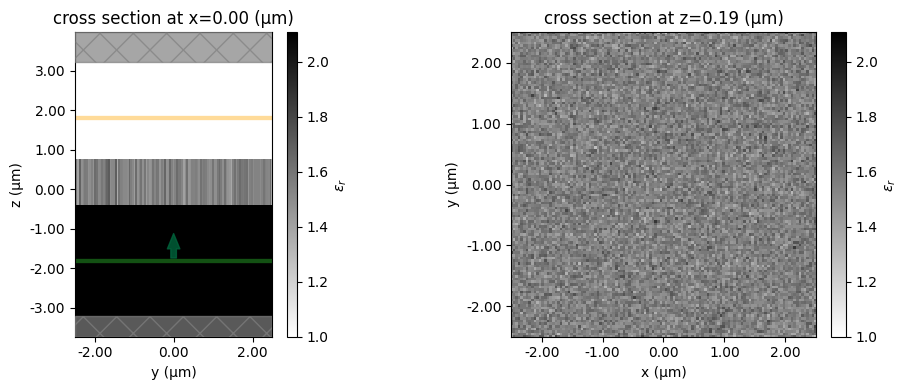

In [37]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
ax1 = sim.plot_eps(x=0, ax=ax1)
ax2 = sim.plot_eps(z=z_center_slab, ax=ax2)
plt.show()

We will also define an auxiliary function to post process and visualize the results.

In [38]:
def post_process(sim_data):
    order = 3
    number_of_orders = (2 * order + 1) ** 2

    # Extract data
    plot_data = sim_data["diffractionmonitor"]
    intensity_measured = plot_data.power
    theta, phi = plot_data.angles
    theta = theta.isel(f=0)
    phi = phi.isel(f=0)
    power_values = plot_data.power.isel(f=0)
    total_power = 0
    # Calculate diffraction orders
    order1, power1, desiredPower1 = [], [], []

    for xorder in intensity_measured.orders_x:
        for yorder in intensity_measured.orders_y:
            val = (
                sim_data["diffractionmonitor"]
                .power.isel(f=0)
                .sel(orders_x=xorder, orders_y=yorder)
                .values
            )
            total_power += val
            if (abs(xorder) <= order) and (abs(yorder) <= order):
                order1.append((int(xorder), int(yorder)))
                power1.append(val)
                desiredPower1.append(1 / number_of_orders)

    rmse = np.sqrt(
        (1 / number_of_orders) * np.sum((np.array(power1) - np.sum(power1) / number_of_orders) ** 2)
    )
    rmse *= 100  # to get percentage

    labels1 = [f"({x},{y})" for x, y in order1]

    # Create a figure with two subplots side by side
    fig = plt.figure(figsize=(10, 4))
    ax_polar = fig.add_subplot(1, 2, 1, projection="polar")
    ax_bar = fig.add_subplot(1, 2, 2)

    # --- Polar plot ---
    sc = ax_polar.scatter(phi, theta, c=power_values, cmap="hot_r")
    fig.colorbar(sc, ax=ax_polar, orientation="vertical", pad=0.1)
    ax_polar.set_title("Far-Field Diffraction Pattern", va="bottom")

    # --- Bar plot ---
    total_power = float(np.sum(power_values))
    ax_bar.bar(
        range(len(power1)),
        100 * np.array(power1) / total_power,
        color="tab:blue",
        label="Measured (nonzero)",
    )

    ax_bar.bar(
        range(len(desiredPower1)),
        np.array(desiredPower1) * 100,
        color="cyan",
        alpha=0.3,
        label="Desired",
    )

    ax_bar.legend()
    ax_bar.set_xticks(range(len(power1)))
    ax_bar.set_xticklabels(labels1, rotation=90, fontsize=8)
    ax_bar.set_xlabel("Diffraction Order (x,y)")
    ax_bar.set_title("Diffraction Monitor Power by Order")

    plt.tight_layout()

    efficiency = sum(power1) / total_power

    print(f"Efficiency: {efficiency:.2f}")
    print(f"RMSE: {rmse:.2f}")

    return efficiency, rmse

Next, we will define a function to analyze the [DiffractionMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.DiffractionMonitor.html) data and evaluate the total power inside the desired diffraction orders, along with a penalty to ensure equal distribution of the intensities.

In [39]:
# Simpler loss function
def intensity_diff_fn(sim_data: td.SimulationData, weight_outside=0.1) -> float:
    """Returns a measure for the amount of difference between desired and target intensity patterns."""

    cost = 0
    orders = 3
    number_of_orders = (2 * orders + 1) ** 2
    total_power = 0
    power = sim_data["diffractionmonitor"].power

    # Total power at the desired orders
    for x, ordersx in enumerate(power.orders_x):
        for y, ordersy in enumerate(power.orders_y):
            power_xy = sim_data["diffractionmonitor"].power.sel(orders_x=ordersx, orders_y=ordersy)
            if (abs(ordersx) <= orders) and (abs(ordersy) <= orders):
                total_power += power_xy

    # Adding the penalty for uneven distribution of the power, and also power at undesired orders
    for x, ordersx in enumerate(power.orders_x):
        for y, ordersy in enumerate(power.orders_y):
            power_xy = sim_data["diffractionmonitor"].power.sel(orders_x=ordersx, orders_y=ordersy)
            if (abs(ordersx) <= orders) and (abs(ordersy) <= orders):
                cost += (total_power / number_of_orders - power_xy) ** 2
            else:
                cost += weight_outside * anp.abs(power_xy) ** 2

    return cost

### Loss Function

Finally, we can create our loss function, which takes as input the parameter list and beta, creates and runs the simulation object, processes the data, and returns the loss, including fabrication constraint penalties. This is the function that will be differentiated using autograd.

It extracts the diffraction orders from the [DiffractionMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.DiffractionMonitor.html), and first calculates the total power as the sum of the intensities of all desired diffraction orders. Next, the function adds to the cost function a penalty for the difference of each order with respect to the mean power, to enforce homogeneity. Finally, the power outside the desired orders is accounted for as a penalty to enforce high efficiency.

In [40]:
def loss_fn(params: anp.ndarray, beta: float) -> tuple[float, dict]:
    """Loss function for the design, the difference in intensity + the feature size penalty."""

    # construct and run the simulation
    sim = make_sim(params, beta=beta)
    sim_data = web.run(sim, task_name="diffractive_beam_splitter", verbose=False)

    processed_params = filter_project(params, beta)
    penalty = erosion_dilation_penalty(processed_params)

    res = intensity_diff_fn(sim_data) ** -1 - 0.2 * penalty
    # grab the respective and total losses
    return res, sim_data.to_static()


loss_fn_val_grad = value_and_grad(loss_fn, has_aux=True)

Before running the optimization, we first check that everything is working correctly.


In [41]:
(val, grad), sim_data = loss_fn_val_grad(params0, beta0)
print("Loss function value: ", val)

/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


Loss function value:  0.8428612064169543


It is also a good sanity check to look at the gradients and confirm they are not all 0.

In [42]:
print(grad)

[[7.19578550e-07 1.32486321e-06 1.14230619e-06 ... 1.36997146e-06
  1.49048363e-06 7.90767959e-07]
 [1.35182458e-06 2.51386933e-06 2.16723897e-06 ... 2.58316094e-06
  2.81786467e-06 1.48286093e-06]
 [1.23703216e-06 2.29903055e-06 1.97851266e-06 ... 2.32331457e-06
  2.55220685e-06 1.34625039e-06]
 ...
 [1.09532956e-06 2.01736531e-06 1.69048942e-06 ... 2.15396342e-06
  2.38280948e-06 1.26060299e-06]
 [1.25026998e-06 2.31402485e-06 1.96634321e-06 ... 2.49427933e-06
  2.74109990e-06 1.44666724e-06]
 [6.74476347e-07 1.23840711e-06 1.05769584e-06 ... 1.33942802e-06
  1.46818082e-06 7.81238958e-07]]


Efficiency: 1.00
RMSE: 13.99


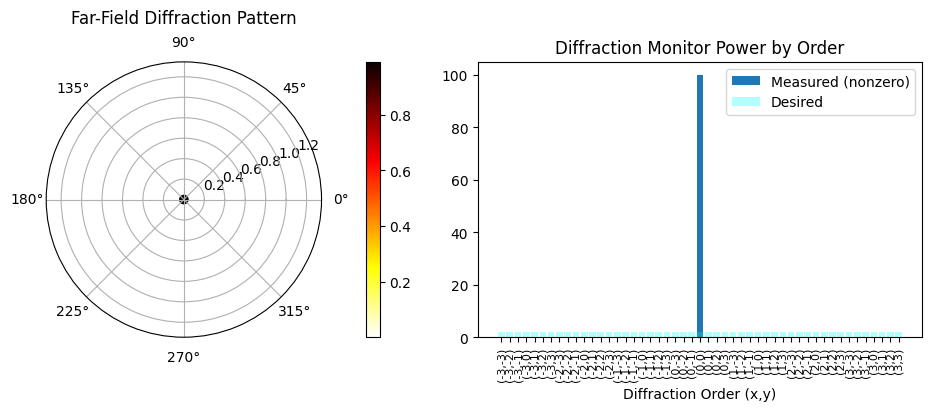

In [43]:
efficiency, rmse = post_process(sim_data)

## Optimize Device

Now we are finally ready to optimize our device.

As in the other tutorials, we use the implementation of "Adam Optimization" from `optax`.

To enable stopping and resuming the optimization, we will create two auxiliary functions to save and load the optimization history.

In [44]:
# File to save the optimization history
history_fname = "misc/diffractive_beam_splitter.pkl"

import optax

num_steps = 80
learning_rate = 1.5
optimizer = optax.adam(learning_rate=learning_rate)


def save_history(history: dict) -> None:
    """Convenience function to save the history to file."""
    with open(history_fname, "wb") as file:
        pickle.dump(history, file)


def load_history() -> dict:
    """Convenience method to load the history from file."""
    with open(history_fname, "rb") as file:
        history = pickle.load(file)
    return history


import pickle

try:
    history = load_history()
    opt_state = history["opt_states"][-1]
    params = history["params"][-1]
    beta = history["betas"][-1]
    num_iters_completed = len(history["params"])
    print("Loaded optimization checkpoint from file.")
    print(f"Found {num_iters_completed} iterations previously completed out of {num_steps} total.")
    if num_iters_completed < num_steps:
        print("Will resume optimization.")
    else:
        print("Optimization completed, will return results.")

except (FileNotFoundError, IndexError):
    print("New optimization")
    params = params0.copy()
    opt_state = optimizer.init(params)
    beta = beta0
    history = dict(
        loss=[], params=[], betas=[], penalty=[], intensity_diff=[], sim_data=[], opt_states=[]
    )

New optimization


step = (0 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 8.429e-01
	beta = 1.00
	|gradient| = 7.629e-04
Efficiency: 1.00
RMSE: 13.99


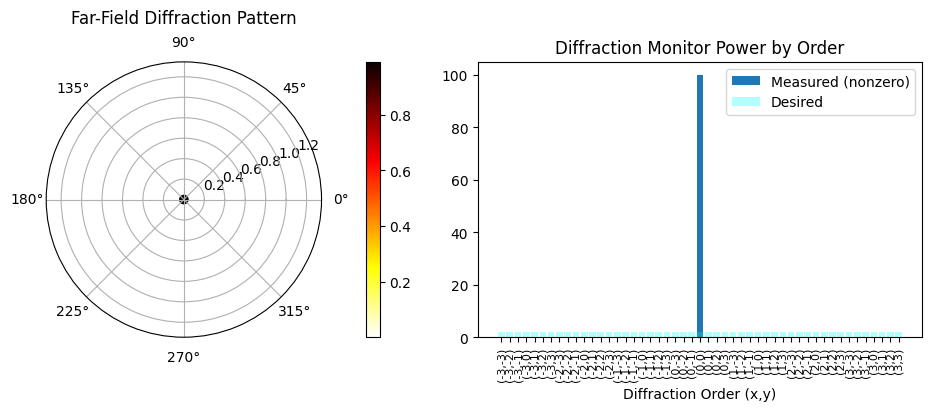

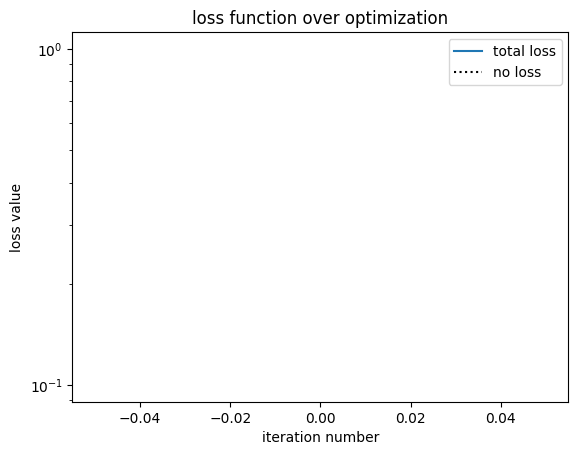

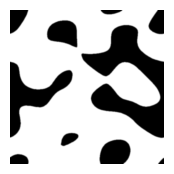

step = (1 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 7.496e+01
	beta = 1.50
	|gradient| = 1.410e+00
step = (2 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 3.058e+01
	beta = 2.00
	|gradient| = 5.548e-01
step = (3 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 6.402e+01
	beta = 2.50
	|gradient| = 1.147e+00
step = (4 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 1.238e+02
	beta = 3.00
	|gradient| = 1.566e+00
step = (5 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 1.705e+02
	beta = 3.50
	|gradient| = 2.008e+00
step = (6 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 2.336e+02
	beta = 4.00
	|gradient| = 2.692e+00
step = (7 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 2.624e+02
	beta = 4.50
	|gradient| = 6.576e+00
step = (8 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 3.470e+02
	beta = 5.00
	|gradient| = 5.168e+00
step = (9 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 3.971e+02
	beta = 5.50
	|gradient| = 8.754e+00
step = (10 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 5.169e+02
	beta = 6.00
	|gradient| = 5.551e+00
Efficiency: 0.80
RMSE: 0.59


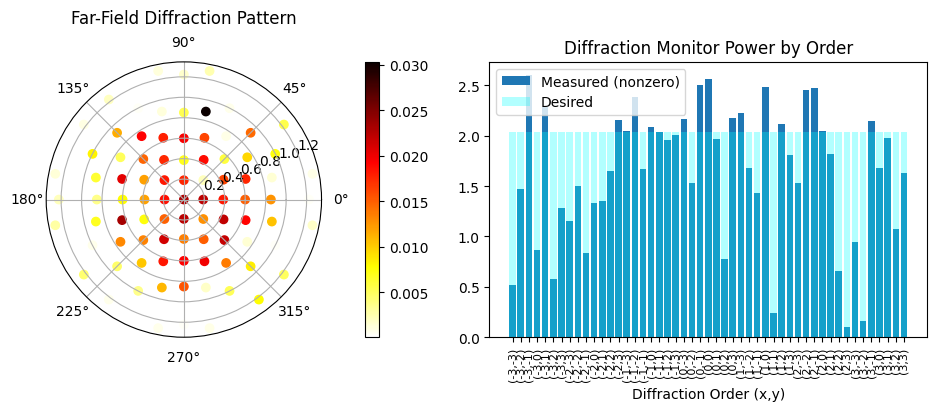

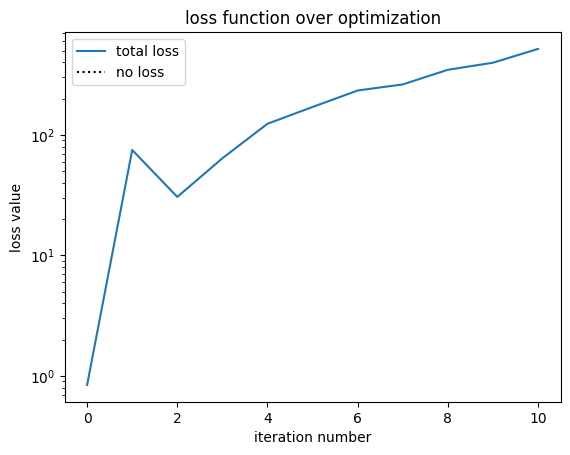

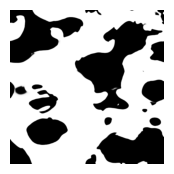

step = (11 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 6.015e+02
	beta = 6.50
	|gradient| = 7.613e+00
step = (12 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 6.967e+02
	beta = 7.00
	|gradient| = 5.377e+00
step = (13 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 8.070e+02
	beta = 7.50
	|gradient| = 4.570e+00
step = (14 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 9.341e+02
	beta = 8.00
	|gradient| = 6.177e+00
step = (15 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 1.110e+03
	beta = 8.50
	|gradient| = 7.826e+00
step = (16 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 1.240e+03
	beta = 9.00
	|gradient| = 1.535e+01
step = (17 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 1.459e+03
	beta = 9.50
	|gradient| = 1.645e+01
step = (18 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 1.750e+03
	beta = 10.00
	|gradient| = 1.746e+01
step = (19 / 80)


01:34:49 PM -03 WARNING: No connection: Retrying for 180 seconds.               

/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 2.149e+03
	beta = 10.50
	|gradient| = 3.255e+01
step = (20 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 2.417e+03
	beta = 11.00
	|gradient| = 6.177e+01
Efficiency: 0.83
RMSE: 0.24


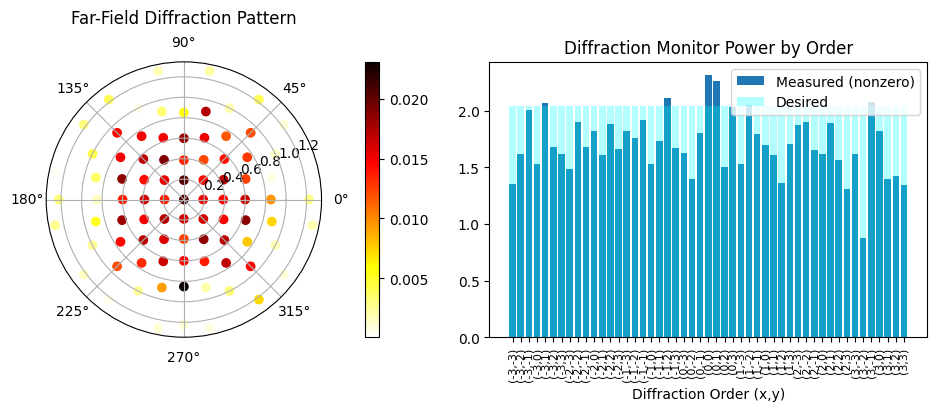

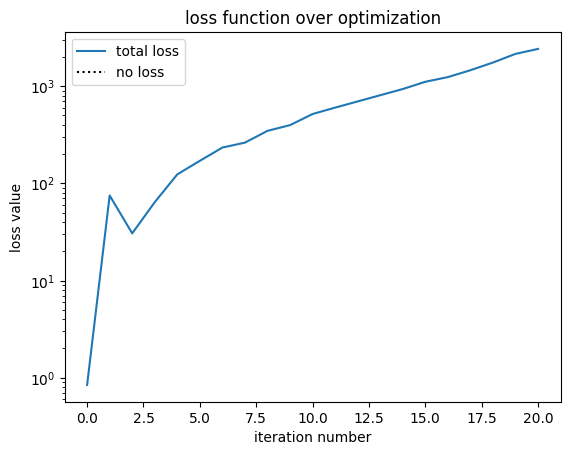

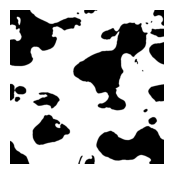

step = (21 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 2.710e+03
	beta = 11.50
	|gradient| = 9.843e+01
step = (22 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 3.260e+03
	beta = 12.00
	|gradient| = 7.893e+01
step = (23 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 3.799e+03
	beta = 12.50
	|gradient| = 7.784e+01
step = (24 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 3.627e+03
	beta = 13.00
	|gradient| = 1.157e+02
step = (25 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 4.611e+03
	beta = 13.50
	|gradient| = 1.058e+02
step = (26 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 4.961e+03
	beta = 14.00
	|gradient| = 9.533e+01
step = (27 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 5.200e+03
	beta = 14.50
	|gradient| = 1.314e+02
step = (28 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 5.575e+03
	beta = 15.00
	|gradient| = 1.603e+02
step = (29 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 5.901e+03
	beta = 15.50
	|gradient| = 1.954e+02
step = (30 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 6.484e+03
	beta = 16.00
	|gradient| = 2.176e+02
Efficiency: 0.85
RMSE: 0.12


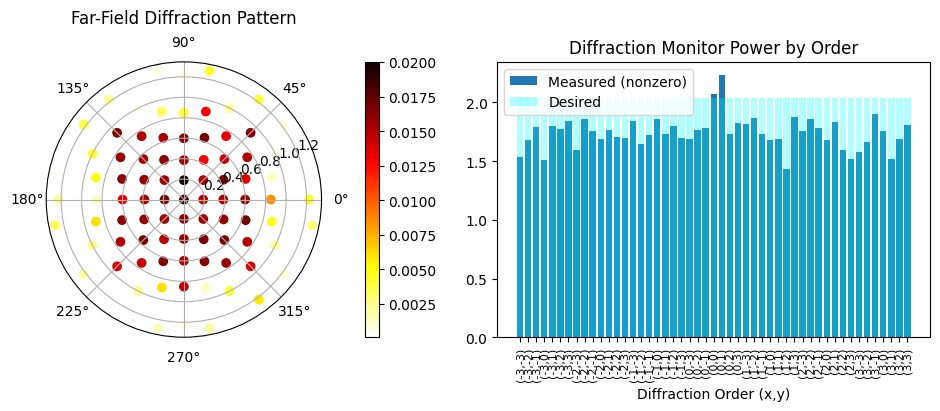

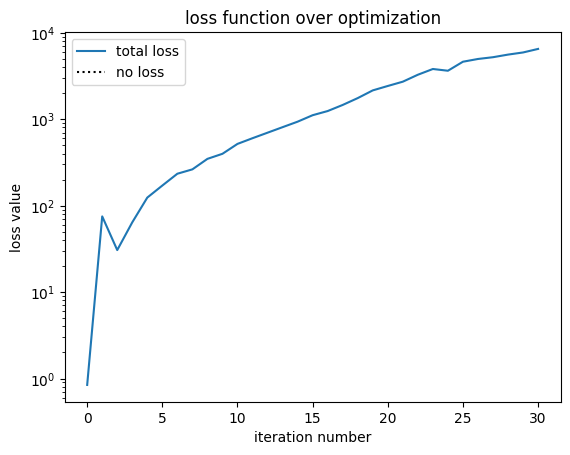

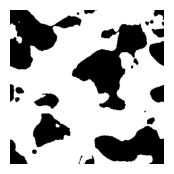

step = (31 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 6.932e+03
	beta = 16.50
	|gradient| = 1.396e+02
step = (32 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 7.371e+03
	beta = 17.00
	|gradient| = 1.074e+02
step = (33 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 7.371e+03
	beta = 17.50
	|gradient| = 1.669e+02
step = (34 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 7.419e+03
	beta = 18.00
	|gradient| = 2.361e+02
step = (35 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 6.433e+03
	beta = 18.50
	|gradient| = 3.486e+02
step = (36 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 7.848e+03
	beta = 19.00
	|gradient| = 3.375e+02
step = (37 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 8.592e+03
	beta = 19.50
	|gradient| = 2.472e+02
step = (38 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 9.259e+03
	beta = 20.00
	|gradient| = 1.939e+02
step = (39 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 9.114e+03
	beta = 20.50
	|gradient| = 2.684e+02
step = (40 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 9.815e+03
	beta = 21.00
	|gradient| = 1.847e+02
Efficiency: 0.86
RMSE: 0.08


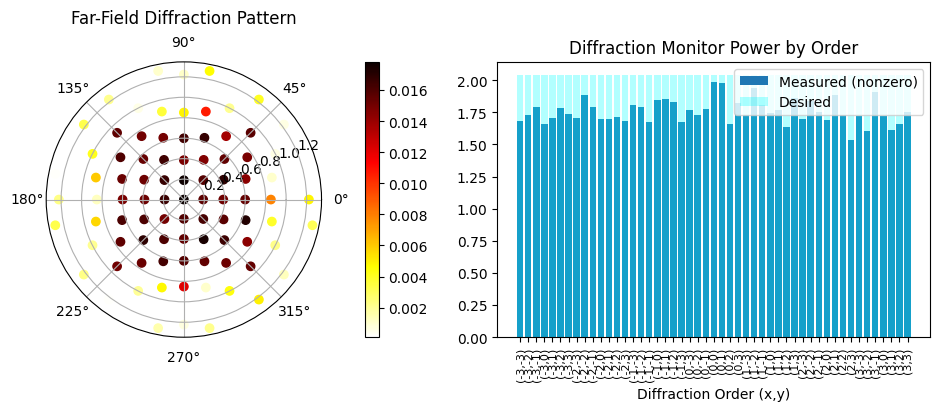

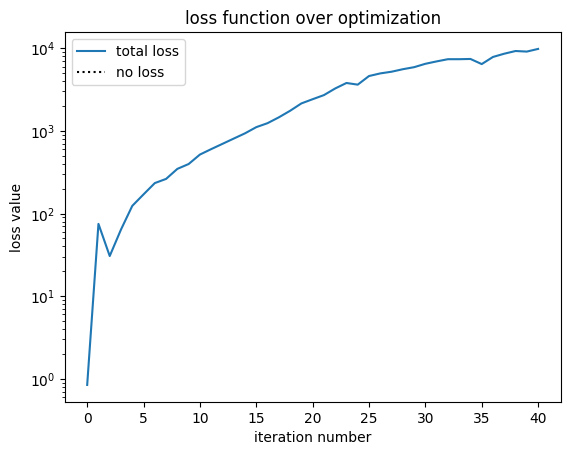

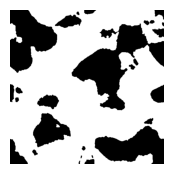

step = (41 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 9.677e+03
	beta = 21.50
	|gradient| = 2.859e+02
step = (42 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 9.119e+03
	beta = 22.00
	|gradient| = 3.660e+02
step = (43 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 9.519e+03
	beta = 22.50
	|gradient| = 3.296e+02
step = (44 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 9.625e+03
	beta = 23.00
	|gradient| = 4.118e+02
step = (45 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 9.022e+03
	beta = 23.50
	|gradient| = 5.039e+02
step = (46 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 9.199e+03
	beta = 24.00
	|gradient| = 6.009e+02
step = (47 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 1.088e+04
	beta = 24.50
	|gradient| = 4.913e+02
step = (48 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 1.094e+04
	beta = 25.00
	|gradient| = 4.558e+02
step = (49 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 1.087e+04
	beta = 25.50
	|gradient| = 5.033e+02
step = (50 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 1.060e+04
	beta = 26.00
	|gradient| = 5.169e+02
Efficiency: 0.87
RMSE: 0.09


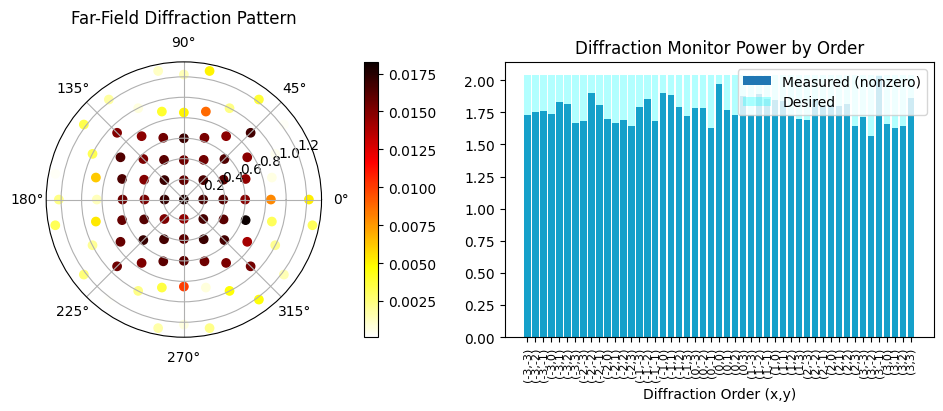

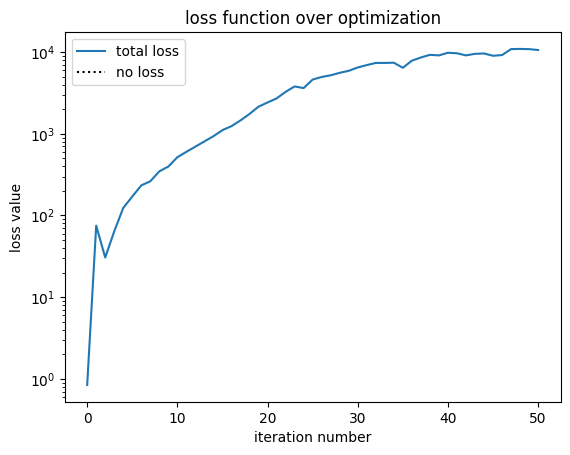

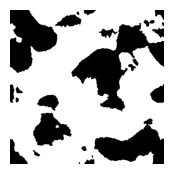

step = (51 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 1.155e+04
	beta = 26.50
	|gradient| = 3.884e+02
step = (52 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 1.176e+04
	beta = 27.00
	|gradient| = 3.711e+02
step = (53 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 1.212e+04
	beta = 27.50
	|gradient| = 5.004e+02
step = (54 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 1.170e+04
	beta = 28.00
	|gradient| = 4.362e+02
step = (55 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 1.271e+04
	beta = 28.50
	|gradient| = 4.019e+02
step = (56 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 1.308e+04
	beta = 29.00
	|gradient| = 3.455e+02
step = (57 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 1.313e+04
	beta = 29.50
	|gradient| = 4.614e+02
step = (58 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 1.174e+04
	beta = 30.00
	|gradient| = 6.497e+02
step = (59 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 1.338e+04
	beta = 30.50
	|gradient| = 5.442e+02
step = (60 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 1.339e+04
	beta = 31.00
	|gradient| = 7.137e+02
Efficiency: 0.87
RMSE: 0.07


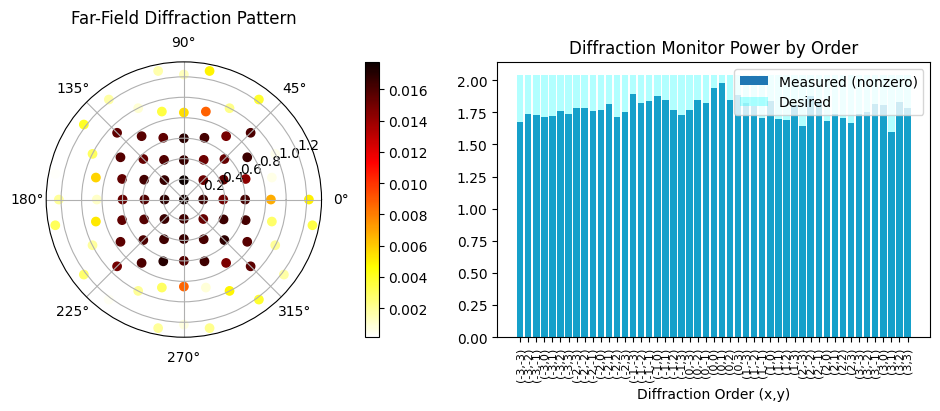

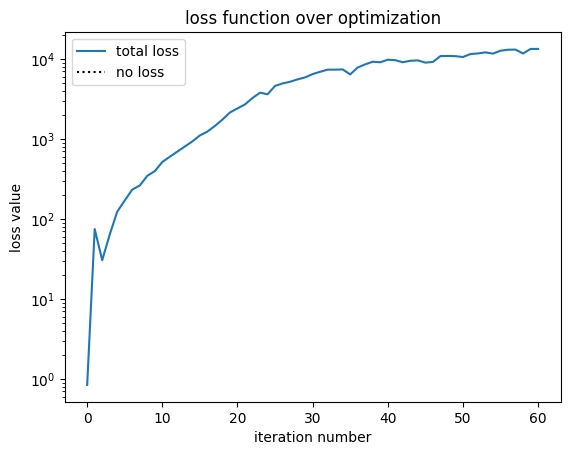

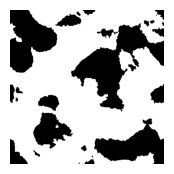

step = (61 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 1.304e+04
	beta = 31.50
	|gradient| = 6.257e+02
step = (62 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 1.371e+04
	beta = 32.00
	|gradient| = 5.146e+02
step = (63 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 1.138e+04
	beta = 32.50
	|gradient| = 6.490e+02
step = (64 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 1.377e+04
	beta = 33.00
	|gradient| = 6.820e+02
step = (65 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


05:47:15 PM -03 WARNING: No connection: Retrying for 180 seconds.               

	loss = 1.038e+04
	beta = 33.50
	|gradient| = 9.593e+02
step = (66 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 1.238e+04
	beta = 34.00
	|gradient| = 8.921e+02
step = (67 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 1.496e+04
	beta = 34.50
	|gradient| = 7.744e+02
step = (68 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 1.038e+04
	beta = 35.00
	|gradient| = 9.753e+02
step = (69 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 1.475e+04
	beta = 35.50
	|gradient| = 7.342e+02
step = (70 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 1.524e+04
	beta = 36.00
	|gradient| = 6.538e+02
Efficiency: 0.88
RMSE: 0.06


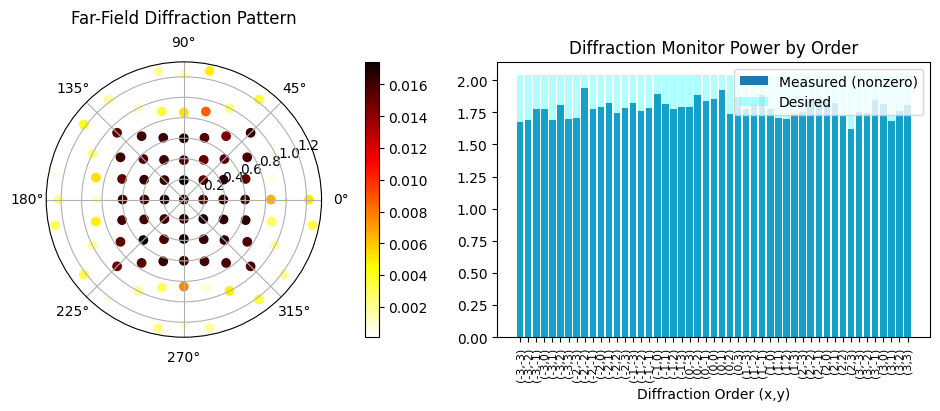

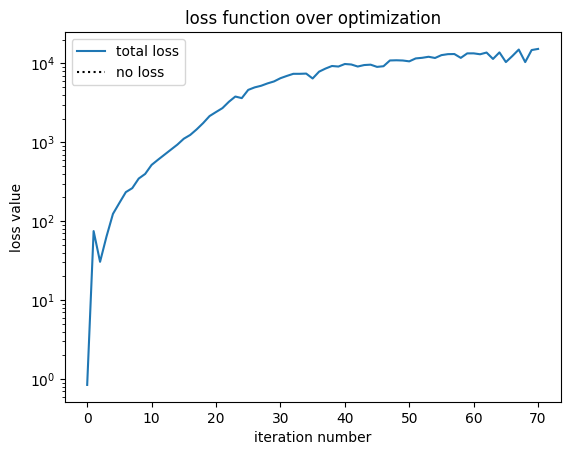

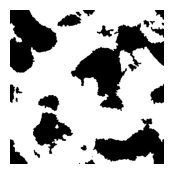

step = (71 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 1.573e+04
	beta = 36.50
	|gradient| = 6.786e+02
step = (72 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 1.350e+04
	beta = 37.00
	|gradient| = 1.054e+03
step = (73 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 1.459e+04
	beta = 37.50
	|gradient| = 1.337e+03
step = (74 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 1.447e+04
	beta = 38.00
	|gradient| = 1.276e+03
step = (75 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 1.519e+04
	beta = 38.50
	|gradient| = 9.826e+02
step = (76 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 1.557e+04
	beta = 39.00
	|gradient| = 1.180e+03
step = (77 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 1.298e+04
	beta = 39.50
	|gradient| = 1.414e+03
step = (78 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 1.729e+04
	beta = 40.00
	|gradient| = 9.220e+02
step = (79 / 80)


/home/filipe/anaconda3/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:72: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.absolute, lambda ans, x : lambda g: g * anp.conj(x) / ans)


	loss = 1.654e+04
	beta = 40.50
	|gradient| = 1.172e+03


In [45]:
# gradually increase the binarization strength over iteration
beta_increment = 0.5
iter_done = len(history["loss"])

if iter_done < num_steps:
    for i in range(iter_done, num_steps):
        print(f"step = ({i} / {num_steps})")

        # compute gradient and current loss function value
        (loss, gradient), sim_data = loss_fn_val_grad(params, beta=beta)

        # save history
        history["loss"].append(loss)
        history["params"].append(params.copy())
        history["betas"].append(beta)
        history["opt_states"].append(opt_state)

        # log some output
        print(f"\tloss = {loss:.3e}")
        print(f"\tbeta = {beta:.2f}")
        print(f"\t|gradient| = {np.linalg.norm(gradient):.3e}")

        # compute and apply updates to the optimizer based on gradient (+1 sign to minimize loss_fn)
        updates, opt_state = optimizer.update(-gradient, opt_state, params)
        params[:] = optax.apply_updates(params, updates)

        # cap the parameters between their bounds
        np.clip(params, 0.0, 1.0, out=params)

        # update the beta value
        beta += beta_increment
        save_history(history)
        if i % 10 == 0:
            efficiency, rmse = post_process(sim_data)
            fig, ax = plt.subplots()
            ax.plot(history["loss"], label="total loss")
            ax.plot(np.zeros_like(history["loss"]), linestyle=":", color="k", label="no loss")
            ax.set_yscale("log")

            ax.set_xlabel("iteration number")
            ax.set_ylabel("loss value")

            ax.set_title("loss function over optimization")
            ax.legend()

            density = filter_project(params, beta)
            plt.subplots(figsize=(2, 2))
            plt.imshow(np.flipud(1 - density.T), cmap="gray")
            plt.axis("off")
            plt.show()

## Analyze Results

First, let's plot the objective function history, and the final permittivity distribution.

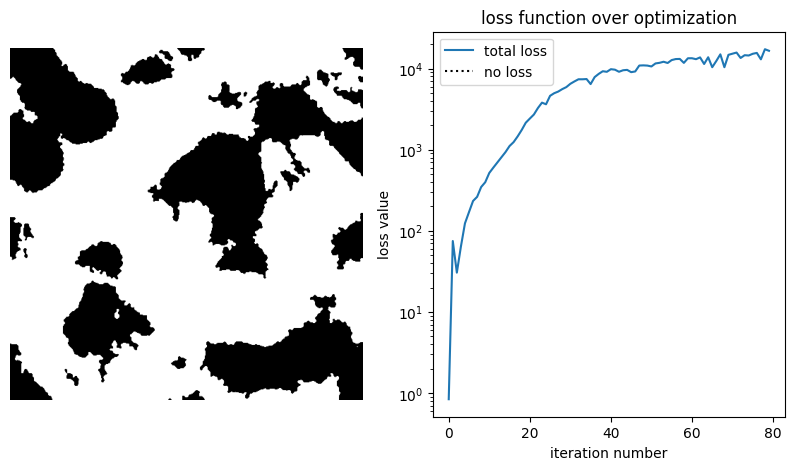

In [46]:
fig, axe = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

params_final = history["params"][-1]
beta_final = history["betas"][-1]

density = filter_project(params_final, beta_final)

axe[0].imshow(np.flipud(1 - density.T), cmap="gray")
axe[0].axis("off")

axe[1].plot(history["loss"], label="total loss")
axe[1].plot(np.zeros_like(history["loss"]), linestyle=":", color="k", label="no loss")
axe[1].set_yscale("log")

axe[1].set_xlabel("iteration number")
axe[1].set_ylabel("loss value")

axe[1].set_title("loss function over optimization")
axe[1].legend()


plt.show()

Now, we can run the final simulation.

In [47]:
sim_final = make_sim(params_final, beta_final)
sim_data_final = web.run(sim_final, task_name="Inspect")

06:46:32 PM -03 Created task 'Inspect' with task_id                             
                'fdve-5a5267f9-5420-44b7-a07b-5ab79932bb47' and task_type       
                'FDTD'.

                View task using web UI at                                       
                ]8;id=291610;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5a5267f9-5420-44b7-a07b-5ab79932bb47\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=553618;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5a5267f9-5420-44b7-a07b-5ab79932bb47\taskId]8;;\]8;id=291610;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5a5267f9-5420-44b7-a07b-5ab79932bb47\=]8;;\]8;id=73701;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5a5267f9-5420-44b7-a07b-5ab79932bb47\fdve]8;;\]8;id=291610;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5a5267f9-5420-44b7-a07b-5ab79932bb47\-5a5267f9-]8;;\
                ]8;id=291610;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5a5267f9-5420-44b7-a07b-5ab79932bb47\5420-44b7-a07b-5ab79932bb47']8;;\.

                Task folder: ]8;id=70685;https://tidy3d.simulation.cloud/folders/folder-f9e994c1-6315-4b44-af3a-c2cb1435b23a\'default']8;;\.

Output()

06:47:22 PM -03 Maximum FlexCredit cost: 0.025. Minimum cost depends on task    
                execution details. Use 'web.real_cost(task_id)' to get the      
                billed FlexCredit cost after a simulation run.

06:47:23 PM -03 status = queued

                To cancel the simulation, use 'web.abort(task_id)' or           
                'web.delete(task_id)' or abort/delete the task in the web UI.   
                Terminating the Python script will not stop the job running on  
                the cloud.

Output()

06:47:30 PM -03 status = preprocess

06:47:35 PM -03 starting up solver

                running solver

Output()

06:47:42 PM -03 early shutoff detected at 52%, exiting.

06:47:43 PM -03 status = postprocess

Output()

06:47:45 PM -03 status = success

06:47:47 PM -03 View simulation result at                                       
                ]8;id=313034;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5a5267f9-5420-44b7-a07b-5ab79932bb47\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=146401;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5a5267f9-5420-44b7-a07b-5ab79932bb47\taskId]8;;\]8;id=313034;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5a5267f9-5420-44b7-a07b-5ab79932bb47\=]8;;\]8;id=616930;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5a5267f9-5420-44b7-a07b-5ab79932bb47\fdve]8;;\]8;id=313034;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5a5267f9-5420-44b7-a07b-5ab79932bb47\-5a5267f9-]8;;\
                ]8;id=313034;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5a5267f9-5420-44b7-a07b-5ab79932bb47\5420-44b7-a07b-5ab79932bb47']8;;\.

Output()

06:47:51 PM -03 loading simulation from simulation_data.hdf5

As we can see, although starting with a random distribution, we can achieve good figures of merit when compared with the reference [paper](https://www.spiedigitallibrary.org/conference-proceedings-of-spie/11261/1126115/Adjoint-method-and-inverse-design-for-diffractive-beam-splitters/10.1117/12.2543367.short).

Although the performance is good, the minimum feature sizes might be too small for some fabrication systems. In that case, it is possible to increase the radius parameter to help enforce larger feature sizes.

Efficiency: 0.88
RMSE: 0.06


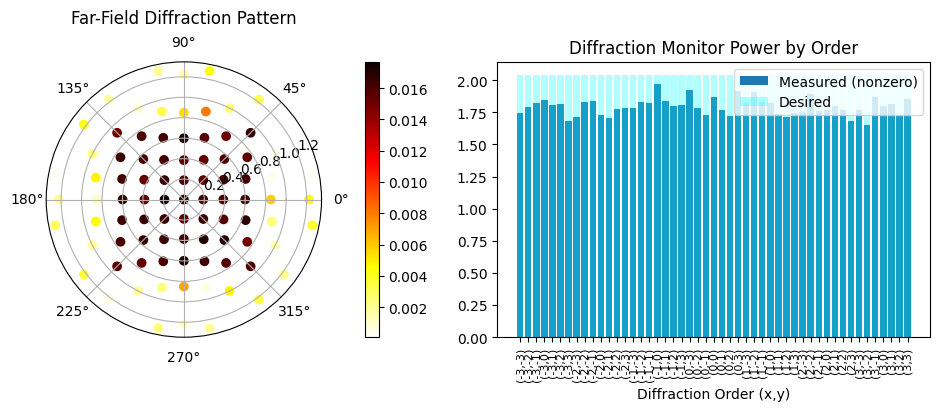

In [48]:
efficiency, rmse = post_process(sim_data_final)